# I. Algorithm

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from math import radians, cos, sin, asin, sqrt
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [133]:
def haversine_distance(data, point):
    '''
        Returns haversine distance between point1 and point2
    '''
    # Convert degrees to radians
    data_rad = np.radians(data)
    point_rad = np.radians(point)

    # Differences
    dlat = data_rad[:, 0] - point_rad[0]
    dlon = data_rad[:, 1] - point_rad[1]

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(point_rad[0]) * np.cos(data_rad[:, 0]) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Earth's radius in kilometers

    return r * c

class dbscan(object):
    def __init__(self, epsilon, k):
        self.epsilon = epsilon
        self.k = k
        self.data = None
        self.labels = None

    def is_corepoint(self, index):
        '''
        Returns True if a point is a corepoint given its index
        '''
        point = self.data[index]
        distances = haversine_distance(self.data, point)
        count = np.sum(distances < self.epsilon)
        return count >= self.k

    def region_query(self, point_index):
        '''
        Returns indices of all points within epsilon distance of point_index
        '''
        point = self.data[point_index]
        distances = haversine_distance(self.data, point)
        neighbors = np.where(distances < self.epsilon)[0]
        return neighbors

    def expand_cluster(self, point_index, neighbors, cluster_id, visited):
        '''
        Expands the cluster with all points that are epsilon distance within a point in the cluster
        '''
        self.labels[point_index] = cluster_id

        i = 0
        while i < len(neighbors):
            neighbor_idx = neighbors[i]

            if not visited[neighbor_idx]:
                visited[neighbor_idx] = True
              
                # Add all points that are epsilon distance to a core point
                if self.is_corepoint(neighbor_idx):
                    new_neighbors = self.region_query(neighbor_idx)
                    neighbors = np.concatenate((neighbors, new_neighbors))
            # If object is currently noise, assign it to cluster
            if self.labels[neighbor_idx] == -1:
                self.labels[neighbor_idx] = cluster_id

            i += 1

    def fit(self, data):
        '''
        Main method to run DBSCAN on the given data
        '''
        self.data = data
        n = data.shape[0]
        self.labels = np.full(n, -1)  # -1 means unclassified / noise
        visited = np.full(n, False)
        cluster_id = 0

        for point_index in range(n):
            if visited[point_index]:
                continue

            visited[point_index] = True
            point = self.data[point_index]

            if not self.is_corepoint(point_index):
                self.labels[point_index] = -1  # noise
            else:
                neighbors = self.region_query(point_index)
                self.expand_cluster(point_index, neighbors, cluster_id, visited)
                cluster_id += 1

        return self.labels

# II. Application to Data Set

We are going to revisit the problem that we explored with $k$-means clustering. This time we will use 
[Haversine Distance](https://en.wikipedia.org/wiki/Haversine_formula) instead of Euclidean distance. Haversine distance accounts for the curvature of the Earth when computing distances.

In [36]:
coaster_data = pd.read_csv("../coaster_db.csv")
cleaned_data = coaster_data[['coaster_name','latitude','longitude']]
cleaned_data.dropna

cleaned_data.head(5)

,coaster_name,latitude,longitude
0,Switchback Railway,40.5740,-73.9780
1,Flip Flap Railway,40.5780,-73.9790
2,Switchback Railway (Euclid Beach Park),41.5800,-81.5700
3,Loop the Loop (Coney Island),40.5745,-73.9780
4,Loop the Loop (Young's Pier),39.3538,-74.4342


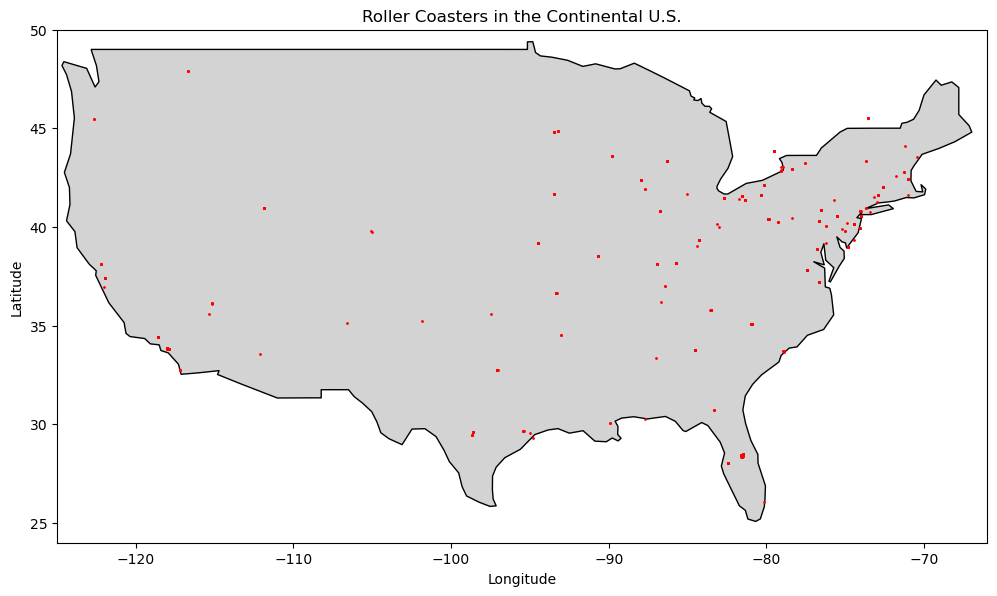

In [85]:
# Restricting Data to U.S. roller coasters based on longitude and latitude
continental_us = cleaned_data[
    (cleaned_data['latitude'] >= 25) & (cleaned_data['latitude'] <= 49) &
    (cleaned_data['longitude'] >= -125) & (cleaned_data['longitude'] <= -60)
]

# Create geometry from longitude and latitude
geometry = [Point(xy) for xy in zip(continental_us['longitude'], continental_us['latitude'])]
geo_df = gpd.GeoDataFrame(continental_us, geometry=geometry, crs='EPSG:4326')  # WGS 84

# Load the built-in low-resolution world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter for United States
usa = world[world['name'] == 'United States of America']

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
usa.plot(ax=ax, color='lightgray', edgecolor='black')
geo_df.plot(ax=ax, color='red', markersize=1)

# Set bounds for continental U.S.
ax.set_xlim(-125, -66)   # Longitude
ax.set_ylim(24, 50)      # Latitude

plt.title('Roller Coasters in the Continental U.S.')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


Here I chose epsilon to be 100 kilometers. If a roller coaster is within 100 kilometers (62 miles), it's very reasonable to drive between them on a trip.

In [125]:
us_coasters_coordinates = continental_us[['longitude','latitude']].to_numpy() # Only Looking at Coordinates

# Creating DSCAN object
d = dbscan(epsilon = 100, k = 8)

# Running Algorithm
labels = d.fit(us_coasters_coordinates)

# Printing number of clusters, clusters start at 0
print(f"There are {max(labels)+1} clusters formed by DBSCAN.")

There are 14 clusters formed by DBSCAN.


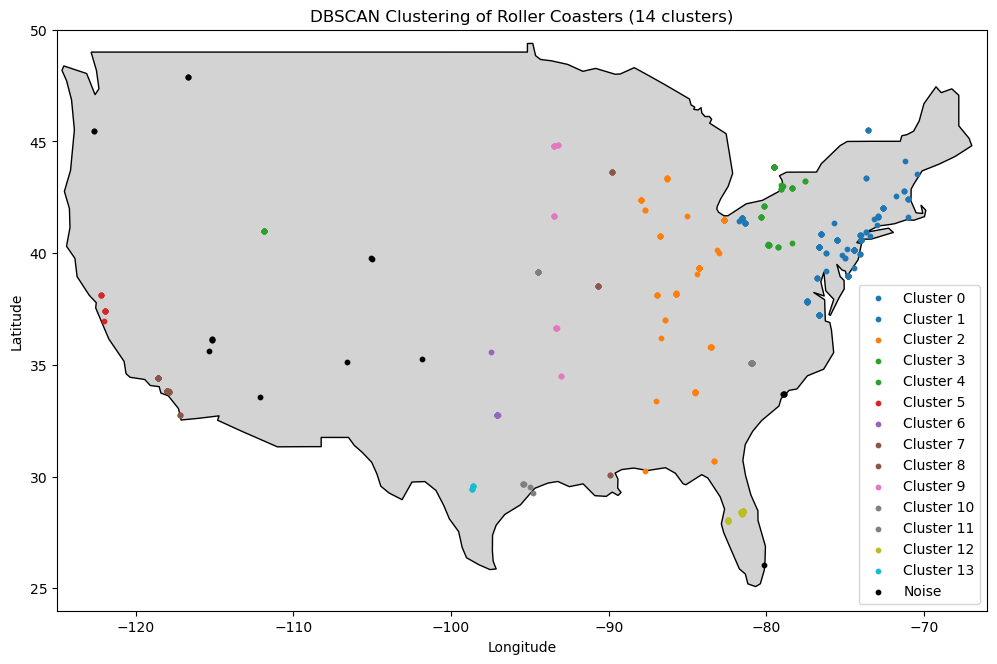

In [134]:
# Convert the coordinate data for plotting
lon = continental_us['longitude'].values
lat = continental_us['latitude'].values

# Number of clusters 
n_clusters = max(labels) + 1

# Create plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the US

usa.plot(ax=ax, color='lightgray', edgecolor='black')

unique_labels = set(labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

# Plot each cluster
for label, color in zip(unique_labels, colors):
    mask = labels == label
    if label == -1:
        # Noise points in black
        color = 'k'
        label_name = 'Noise'
    else:
        label_name = f'Cluster {label}'
    plt.scatter(lon[mask], lat[mask], c=[color], label=label_name, s=10)


# Set bounds for continental U.S.
ax.set_xlim(-125, -66)   # Longitude
ax.set_ylim(24, 50)      # Latitude

plt.title(f'DBSCAN Clustering of Roller Coasters ({n_clusters} clusters)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


Let's look at the distribution of the sizes of each cluster.

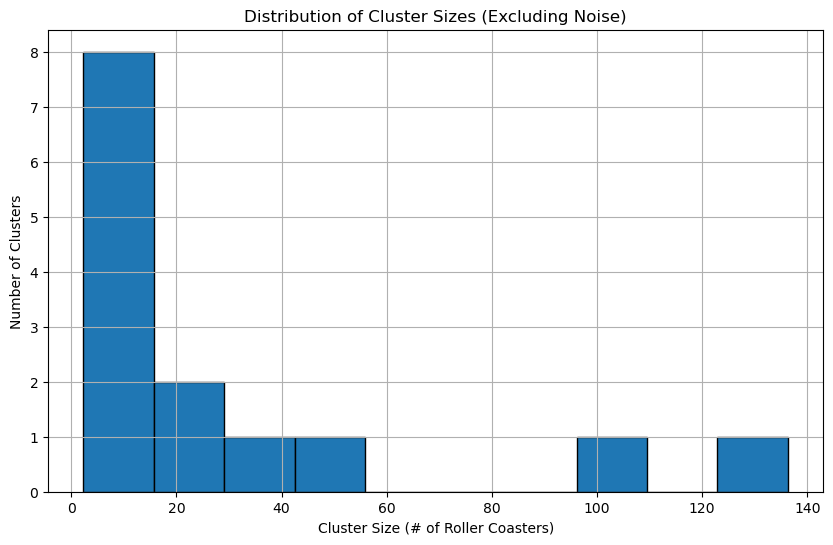

In [130]:
# Exclude noise (-1) if desired
filtered_labels = labels[labels != -1]

# Count points in each cluster
(unique, counts) = np.unique(filtered_labels, return_counts=True)

# Plot histogram of cluster sizes
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=10, edgecolor='black', align='left')
plt.title('Distribution of Cluster Sizes (Excluding Noise)')
plt.xlabel('Cluster Size (# of Roller Coasters)')
plt.ylabel('Number of Clusters')
plt.grid(True)
plt.show()

We can clearly see a right skew, with most clusters having less than 20 coasters. However, there was 1 cluster with over 100 roller coasters.

In [131]:
# Count occurrences of each cluster label
unique, counts = np.unique(filtered_labels, return_counts=True)

# Get cluster with max count
max_cluster = unique[np.argmax(counts)]
max_count = counts[np.argmax(counts)]

print(f"Cluster with the most data points: {max_cluster}")
print(f"Number of points in that cluster: {max_count}")

Cluster with the most data points: 0
Number of points in that cluster: 143


Wow! It seems like the New England cluster is where you want to be if you want to be surrounded by roller coasters within driving distance!

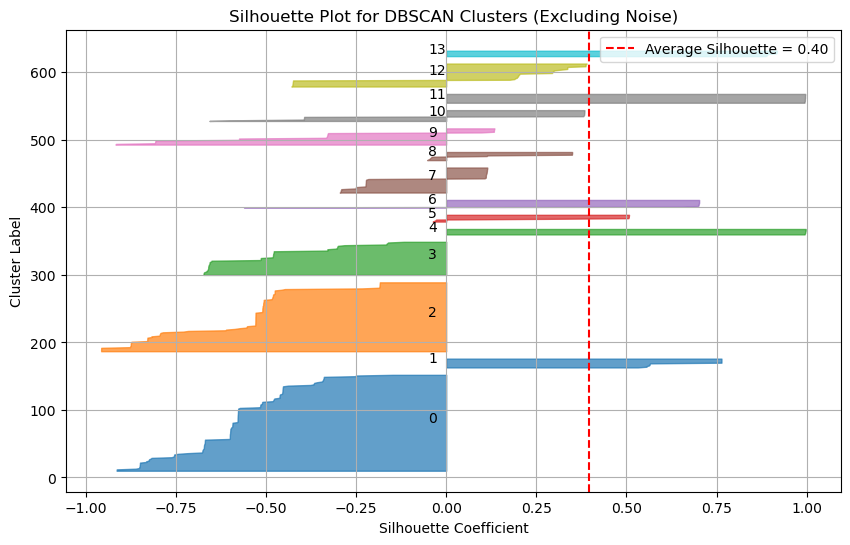

In [142]:
# Filter out noise for silhouette analysis
mask = labels != -1
filtered_coords = us_coasters_coordinates[mask]
filtered_labels = labels[mask]

# Compute silhouette scores
silhouette_vals = silhouette_samples(filtered_coords, filtered_labels, metric='haversine')  
avg_score = silhouette_score(filtered_coords, filtered_labels)

# Get number of clusters
n_clusters = len(set(filtered_labels))

# Start plotting
fig, ax = plt.subplots(figsize=(10, 6))

y_lower = 10
for i, cluster in enumerate(sorted(set(filtered_labels))):
    cluster_vals = silhouette_vals[filtered_labels == cluster]
    cluster_vals.sort()
    size = len(cluster_vals)
    y_upper = y_lower + size

    color = cm.tab10(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_vals,
                     facecolor=color, edgecolor=color, alpha=0.7)

    ax.text(-0.05, y_lower + 0.5 * size, str(cluster))
    y_lower = y_upper + 10

ax.axvline(avg_score, color="red", linestyle="--", label=f"Average Silhouette = {avg_score:.2f}")
ax.set_title("Silhouette Plot for DBSCAN Clusters (Excluding Noise)")
ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Cluster Label")
ax.legend()
plt.grid(True)
plt.show()


A silhouette plot helps us visualize the distinctiveness between clusters. Each point gets a silhouette score:

$ s = \frac{b-a}{\text{max}(a,b)} $
 
where $a$ = average distance to other points in the same cluster, $b$ = average distance to points in the nearest neighboring cluster, and $s$ ranges from -1 to 1.

A good cluster should have a silhouette score close to 1. We can see that some of our clusters have high silhouette coefficients but those usually correspond to the clusters with smaller sizes. This is because with DBSCAN, we get pretty irregularly shaped clusters. Thus, points from neighboring clusters may be close to each other despite not being in the same cluster. 

Ultimately, our model is able to create general groupings of roller coasters in the United States, with some clusters being quite large and others being small. Compared to $k$-means clustering, DBSCAN is definitley more irregular in the cluster shapes and sizes. Under this clustering, more driving is required to visit the roller coasters within a single cluster.